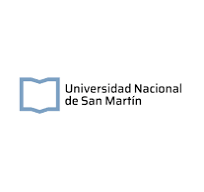

#### Procesamiento Digital de Señales - Primer cuatrimestre 2025

# Trabajo Práctico Nº2
#### Matías Cassino


# Consignas

Simulamos el bloque de cuantización de un ADC de B bits en un rango de  ±VF
Volts. Ahora vamos a completar la simulación del ADC incluyendo la capacidad de muestrear a fs Hertz.

Para ello se simulará el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido. Comenzaremos describiendo los parámetros a ajustar de la senoidal:

- frecuencia $f_0$
 arbitraria, por ejemplo 
     \begin{equation}
        f_0 = \frac{f_S}{N} = \Delta f
    \end{equation}
 
- energía normalizada, es decir energía (o varianza) unitaria.

Con respecto a los parámetros de la secuencia de ruido, diremos que:
- será de carácter aditivo, es decir, la señal que entra al ADC será:
    \begin{equation}
        s_R = s + n
    \end{equation}
    Siendo $n$ la secuencia que simula la interferencia, y $s$ la senoidal descrita anteriormente.
- La potencia del ruido será:
\begin{equation}
        P_n = k_n P_q \quad \text{W}
    \end{equation}
    siendo el factor $k_n$ una escala para la potencia del ruido de cuantización:
    \begin{equation}
        P_q = \frac{q^2}{12}
    \end{equation}
- Finalmente, n será incorrelado y Gaussiano.
  
El ADC que deseamos simular trabajará a una frecuencia de muestreo:
\begin{equation}
    f_S = 1000 \text{ Hz}
\end{equation}
y tendrá un rango analógico de:
\begin{equation}
    \pm V_F = 2 \text{ Volts}
\end{equation}

A) Generar el siguiente resultado producto de la experimentación. $B$ = 4 bits, $k_n$ = 1.
i: señal temporal
ii: espectro
iii: histograma

B) Analizar para una de las siguientes configuraciones $B = ̣4, 8, 16$ bits, $k_n= 1/10,1,10$. Discutir los resultados respecto a lo obtenido en a).

Bonus 1) Encontrar la relación entre la cantidad de B bits del ADC y el SNR de la señal digitalizada. 

Bonus 2) Simular el efecto del aliasing junto con el muestreo.


## Resolución A

### Código asociado a la consigna A

In [1]:
#%% Módulos y funciones a importar
import numpy as np
import matplotlib.pyplot as plt

#%% Datos de la simulación
fs = 1000  # frecuencia de muestreo (Hz)
N = 1000 # cantidad de muestras

# Datos del ADC
B = 4 # bits
Vf = 2 # rango simétrico de +/- Vf Volts
q = 2*Vf/(2**B) # paso de cuantización de q Volts 2*Vf/2**B

# Datos del ruido 
Pq = (q**2)/12# Potencia del ruido de cuantización en Watts
kn = 1 # escala de la potencia del ruido de cuantización
Pn = Pq * kn # Potencia del ruido analógico

ts = 1/fs # tiempo de muestreo
df = fs/N # resolución espectral

# Señales
tt = np.linspace(0, (N-1)*ts, N)
f0=1
amplitud = np.sqrt(2)
analog_sig_sn=amplitud * np.sin( 2 * np.pi * f0 * tt )# señal analógica sin ruido no normalizada
s = analog_sig_sn/np.var(analog_sig_sn)# señal analógica sin ruido de energia normalizada (varianza=1) y potencia 1W

n =  np.random.normal(0, np.sqrt(Pn),N) # señal de ruido analogico Gaussiano e incorrelado
sr = s + n # señal analógica de entrada al ADC (señal + ruido analógico)
srq = np.round(sr/q)*q  # señal cuantizada (escalo a valor palabra y luego vuelvo a mi escala)
nq = srq - sr # señal de ruido de cuantización (señal cuantizada - señal con ruido analogico).

#FFT
ft_SR = 1/N*np.fft.fft( sr)
ft_Srq = 1/N*np.fft.fft( srq)
ft_As = 1/N*np.fft.fft( s)
ft_Nq = 1/N*np.fft.fft( nq)
ft_Nn = 1/N*np.fft.fft( n)

# grilla de sampleo frecuencial
ff = np.linspace(0, (N-1)*df, N)
bfrec = ff <= fs/2

#valor de la media
Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

bins = 10

### Resultados de la consigna A

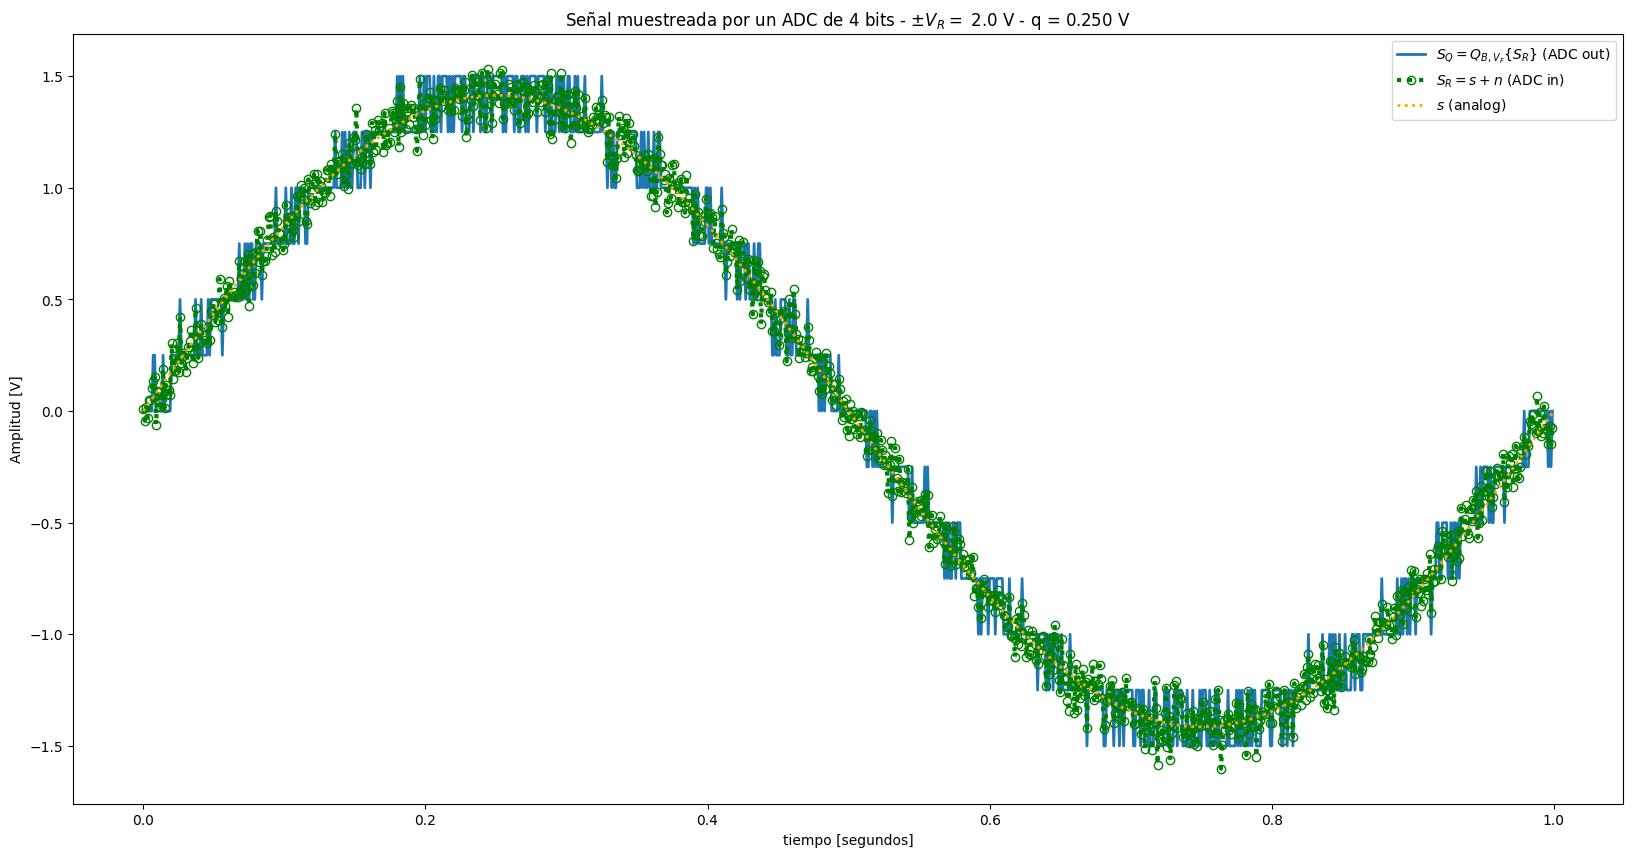

Text(0.5, 0, 'Pasos de cuantización (q) [V]')

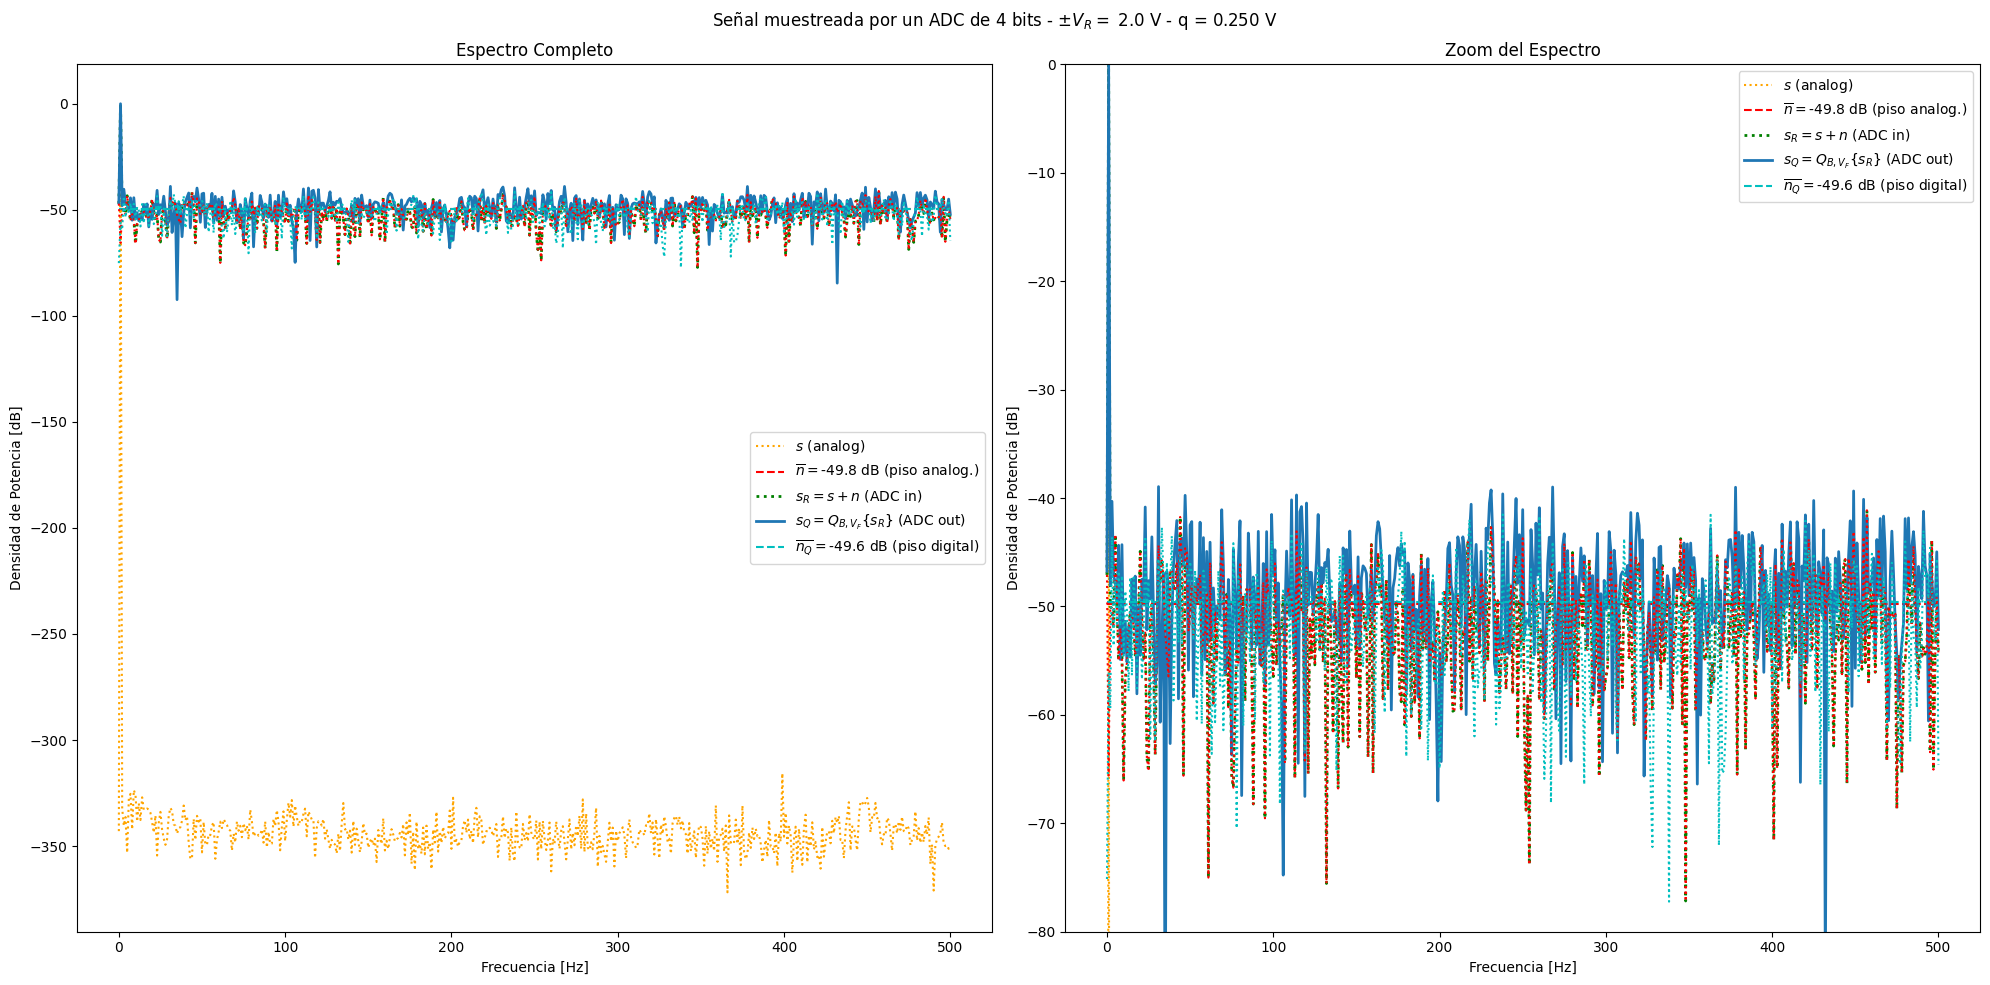

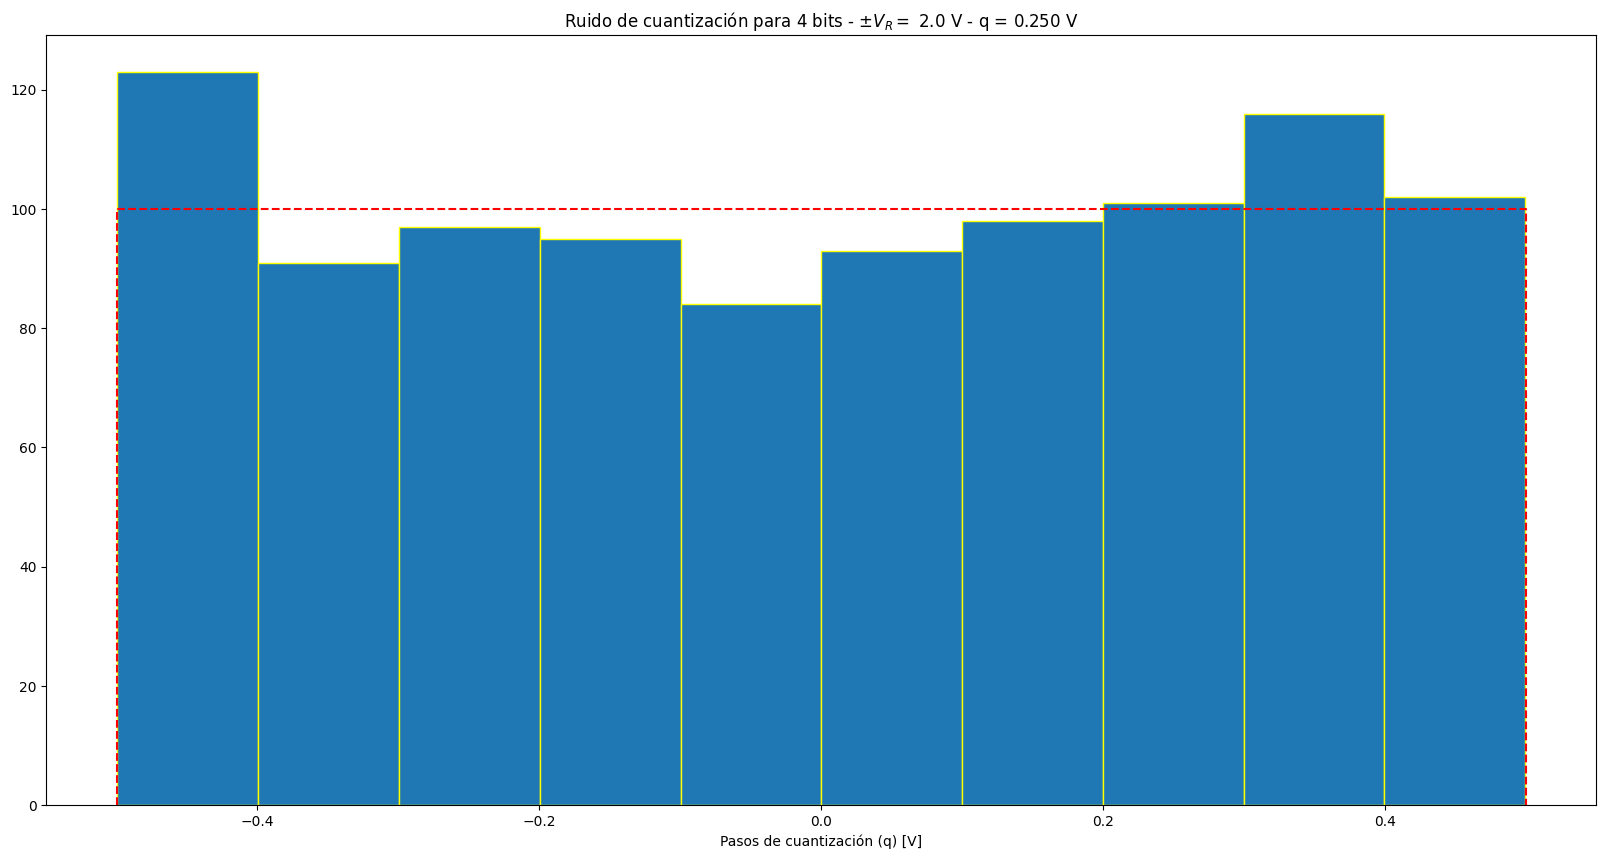

In [2]:
#%% Visualización de resultados A

# cierro ventanas anteriores
plt.close('all')

##################
# Señal temporal
##################

plt.figure(1, figsize=(20, 10))

plt.plot(tt, srq, lw=2, linestyle='-', fillstyle='none', label=r'$S_Q = Q_{B,V_F}\{S_R\}$ (ADC out)')
plt.plot(tt, sr, lw=3, color='green', marker='o', markerfacecolor='none', markeredgecolor='green', ls='dotted', label=r'$S_R = s + n$ (ADC in)')
plt.plot(tt,s, lw=2, color='orange', linestyle='dotted', label=r'$s$ (analog)')

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')  
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()


# ###########
# # Espectro
# ###########

# Crear figura con subplots
plt.figure(2, figsize=(20, 10))
plt.suptitle('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )

#Espectro
plt.subplot(1,2,1)
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_As[bfrec]) ** 2), color='orange', ls='dotted', label='$ s $ (analog)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([nNn_mean, nNn_mean])), '--r', label='$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10 * np.log10(2 * nNn_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR[bfrec]) ** 2), ':g', lw=2, label='$ s_R = s + n $ (ADC in)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq[bfrec]) ** 2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\}$ (ADC out)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([Nnq_mean, Nnq_mean])), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10 * np.log10(2 * Nnq_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nn[bfrec]) ** 2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq[bfrec]) ** 2), ':c')
plt.title('Espectro Completo')
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()

#Zoom al espectro
plt.subplot(1,2,2)
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_As[bfrec]) ** 2), color='orange', ls='dotted', label='$ s $ (analog)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([nNn_mean, nNn_mean])), '--r', label='$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10 * np.log10(2 * nNn_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR[bfrec]) ** 2), ':g', lw=2, label='$ s_R = s + n $ (ADC in)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq[bfrec]) ** 2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\}$ (ADC out)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([Nnq_mean, Nnq_mean])), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10 * np.log10(2 * Nnq_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nn[bfrec]) ** 2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq[bfrec]) ** 2), ':c')
plt.title('Zoom del Espectro')
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()
plt.ylim(-80, 0)

plt.tight_layout()


# #############
# # Histograma
# #############

plt.figure(3, figsize=(20,10))
plt.hist(nq.flatten()/(q), bins=bins, edgecolor='yellow')
plt.plot( np.array([-1/2, -1/2, 1/2, 1/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
plt.xlabel('Pasos de cuantización (q) [V]')

### Análisis de resultados de la consigna A
A partir del gráfico en el dominio del tiempo de la senoidal y la secuenia afectada por ruido analógico y digital, se comprende que los cambios entre valores inferiores a $q$, se pierden en la cuantización. También, la señal cuantizada a la salida del ADC $(S_Q)$ presenta una mayor distorsión a causa de sus valores discretos, lo cual se aprecia en el eje temporal fundamentalmente alrededor de los ceros de la función. Además, la señal con ruido analógico previa a entrar al ADC $(S_R)$ exhibe su dispersión en toda la secuencia respecto a la señal original. En efecto ambos tipos de ruidos afectan a la calidad de la señal.

En adición, el gráfico asociado al espectro en el dominio de frecuencia permite distinguir que el máximo de la señal se encuentra a 0 db debido a que la señal acumula 1 W de densidad de potencia en 1 Hz, y el ruido introducido por la cuantización no reduce ni amplifica el ruido analógico ya que se encuentran al mismo nivel/piso de potencia, específicamente, -49.8 db.

A su vez, el histograma del ruido de cuantización permite deducir su carácter de distribución uniforme ante el redondeo.

## Resolución B

### Código asociado a la consigna B

In [3]:
#%% Datos de la simulación 2 (B=4 y Kn=1/10)
# Datos del ADC 
B2 = 4 # bits
q2 = 2*Vf/(2**B2) # paso de cuantización de q Volts 2*Vf/2**B

# datos del ruido 
Pq2 = (q2**2)/12#Potencia del ruido de cuantización en Watts
kn2 = 1/10 # escala de la potencia del ruido de cuantización
Pn2 = Pq2 * kn2 #Potencia del ruido analógico

# Señales
n2 =  np.random.normal(0, np.sqrt(Pn2),N) # señal de ruido analogico Gaussiano e incorrelado
sr2 = s + n2# señal analógica de entrada al ADC (señal + ruido analógico)
srq2 = np.round(sr2/q2)*q2  # señal cuantizada (escalo a valor palabra y luego vuelvo a mi escala)
nq2 = srq2 - sr2 # señal de ruido de cuantización (señal cuantizada - señal con ruido analogico). 

#%% Datos de la simulación 3 (B=8 y Kn=1)
# Datos del ADC 
B3 = 8 # bits
q3 = 2*Vf/(2**B3) # paso de cuantización de q Volts 2*Vf/2**B

# datos del ruido 
Pq3 = (q3**2)/12#Potencia del ruido de cuantización en Watts
kn3 = 1 # escala de la potencia del ruido de cuantización
Pn3 = Pq3 * kn3 #Potencia del ruido analógico

# Señales
n3 =  np.random.normal(0, np.sqrt(Pn3),N) # señal de ruido analogico Gaussiano e incorrelado
sr3 = s + n3# señal analógica de entrada al ADC (señal + ruido analógico)
srq3 = np.round(sr3/q3)*q3  # señal cuantizada (escalo a valor palabra y luego vuelvo a mi escala)
nq3 = srq3 - sr3 # señal de ruido de cuantización (señal cuantizada - señal con ruido analogico). 

#%% Datos de la simulación 4 (B=16 y Kn=10)
# Datos del ADC 
B4 = 16 # bits
q4 = 2*Vf/(2**B4) # paso de cuantización de q Volts 2*Vf/2**B

# datos del ruido 
Pq4 = (q4**2)/12#Potencia del ruido de cuantización en Watts
kn4 = 10 # escala de la potencia del ruido de cuantización
Pn4 = Pq4 * kn4 #Potencia del ruido analógico

# Señales
n4 =  np.random.normal(0, np.sqrt(Pn4),N) # señal de ruido analogico Gaussiano e incorrelado
sr4 = s + n4# señal analógica de entrada al ADC (señal + ruido analógico)
srq4 = np.round(sr4/q4)*q4  # señal cuantizada (escalo a valor palabra y luego vuelvo a mi escala)
nq4 = srq4 - sr4 # señal de ruido de cuantización (señal cuantizada - señal con ruido analogico). 

#FFT de la simulación 2
ft_SR2 = 1/N*np.fft.fft( sr2)
ft_Srq2 = 1/N*np.fft.fft( srq2)
ft_Nq2 = 1/N*np.fft.fft( nq2)
ft_Nn2 = 1/N*np.fft.fft( n2)

#valor de la media de simulación 2
Nnq2_mean = np.mean(np.abs(ft_Nq2)**2)
nNn2_mean = np.mean(np.abs(ft_Nn2)**2)

#FFT de la simulación 3
ft_SR3 = 1/N*np.fft.fft( sr3)
ft_Srq3 = 1/N*np.fft.fft( srq3)
ft_Nq3 = 1/N*np.fft.fft( nq3)
ft_Nn3 = 1/N*np.fft.fft( n3)

#valor de la media de simulación 3
Nnq3_mean = np.mean(np.abs(ft_Nq3)**2)
nNn3_mean = np.mean(np.abs(ft_Nn3)**2)

#FFT de la simulación 4
ft_SR4 = 1/N*np.fft.fft( sr4)
ft_Srq4 = 1/N*np.fft.fft( srq4)
ft_Nq4 = 1/N*np.fft.fft( nq4)
ft_Nn4 = 1/N*np.fft.fft( n4)

#valor de la media de simulación 4
Nnq4_mean = np.mean(np.abs(ft_Nq4)**2)
nNn4_mean = np.mean(np.abs(ft_Nn4)**2)

bins = 10

### Resultados de la consigna B

C:\Users\Nancy\AppData\Local\Temp\ipykernel_18188\51286412.py:106: RuntimeWarning: divide by zero encountered in log10
  plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq4[bfrec]) ** 2), lw=2, label='$ s_Q4 = Q_{B,V_F}\{s_R\}$ (ADC out)')
C:\Users\Nancy\AppData\Local\Temp\ipykernel_18188\51286412.py:120: RuntimeWarning: divide by zero encountered in log10
  plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq4[bfrec]) ** 2), lw=2, label='$ s_Q4 = Q_{B,V_F}\{s_R\}$ (ADC out)')


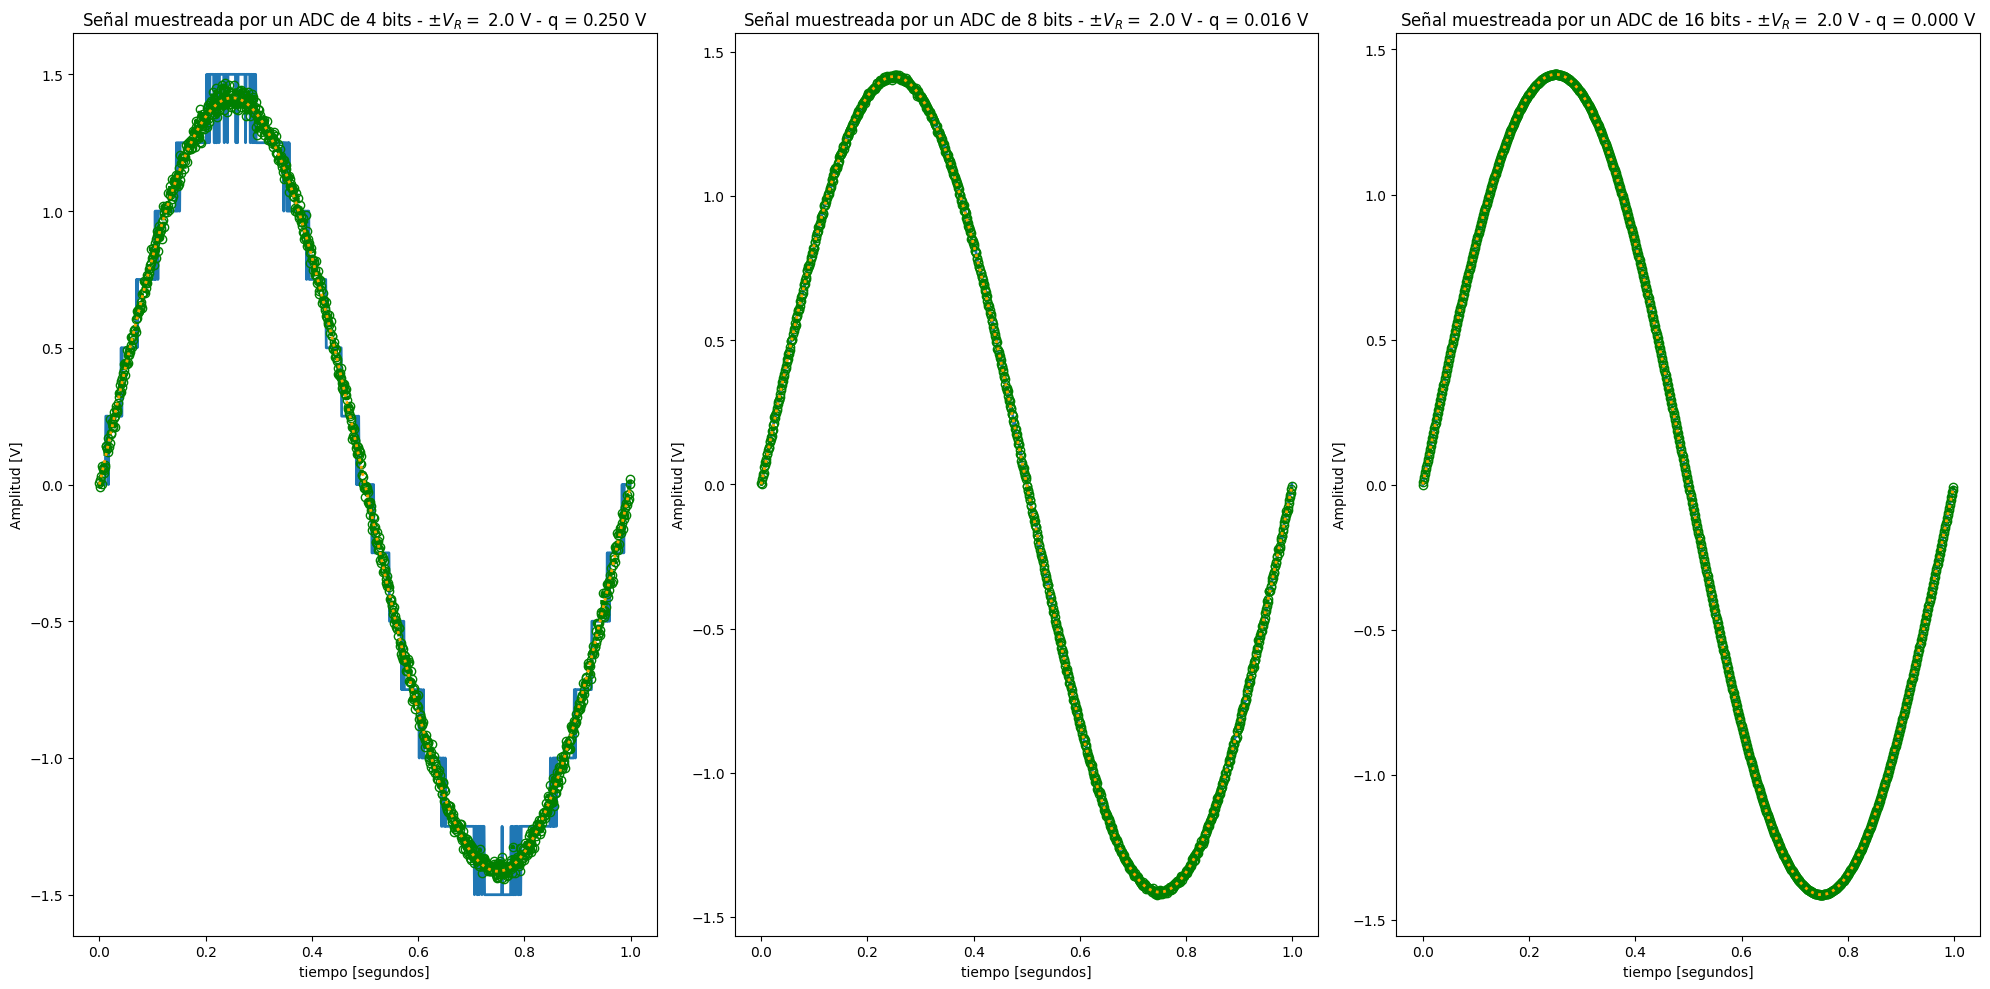

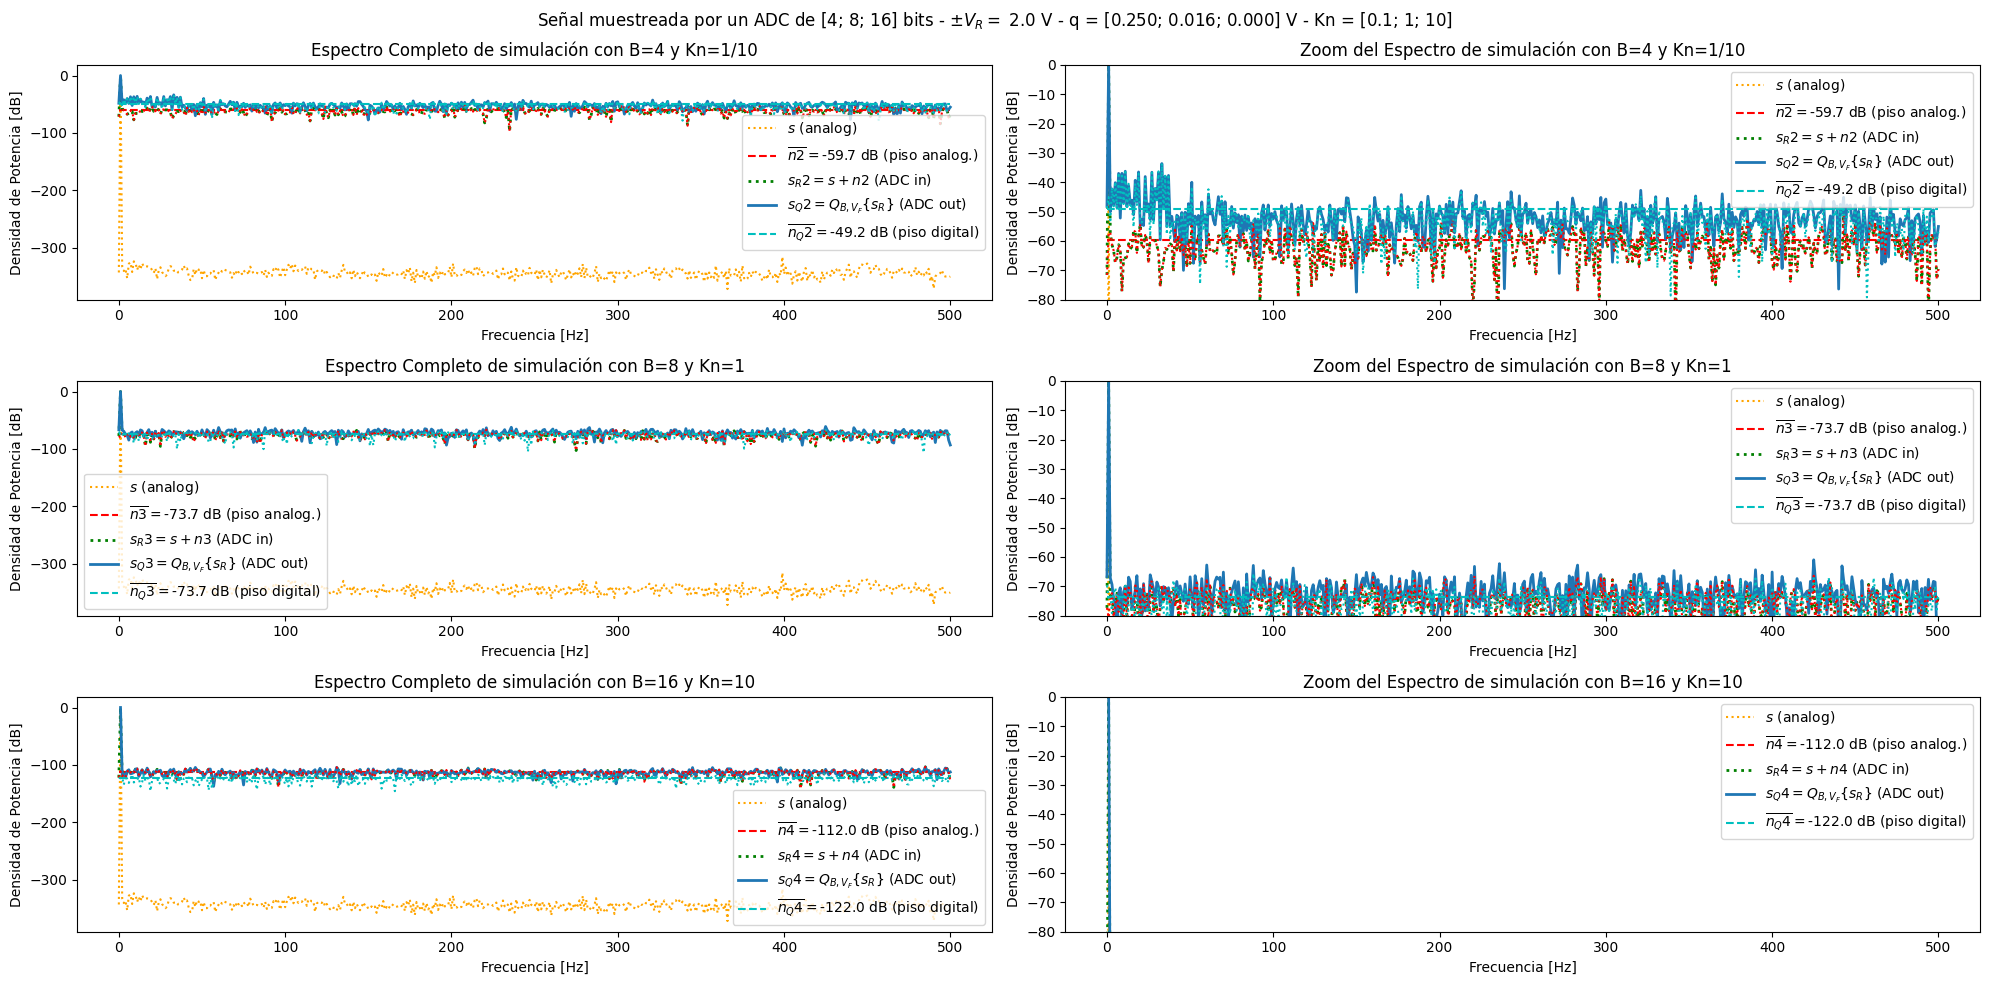

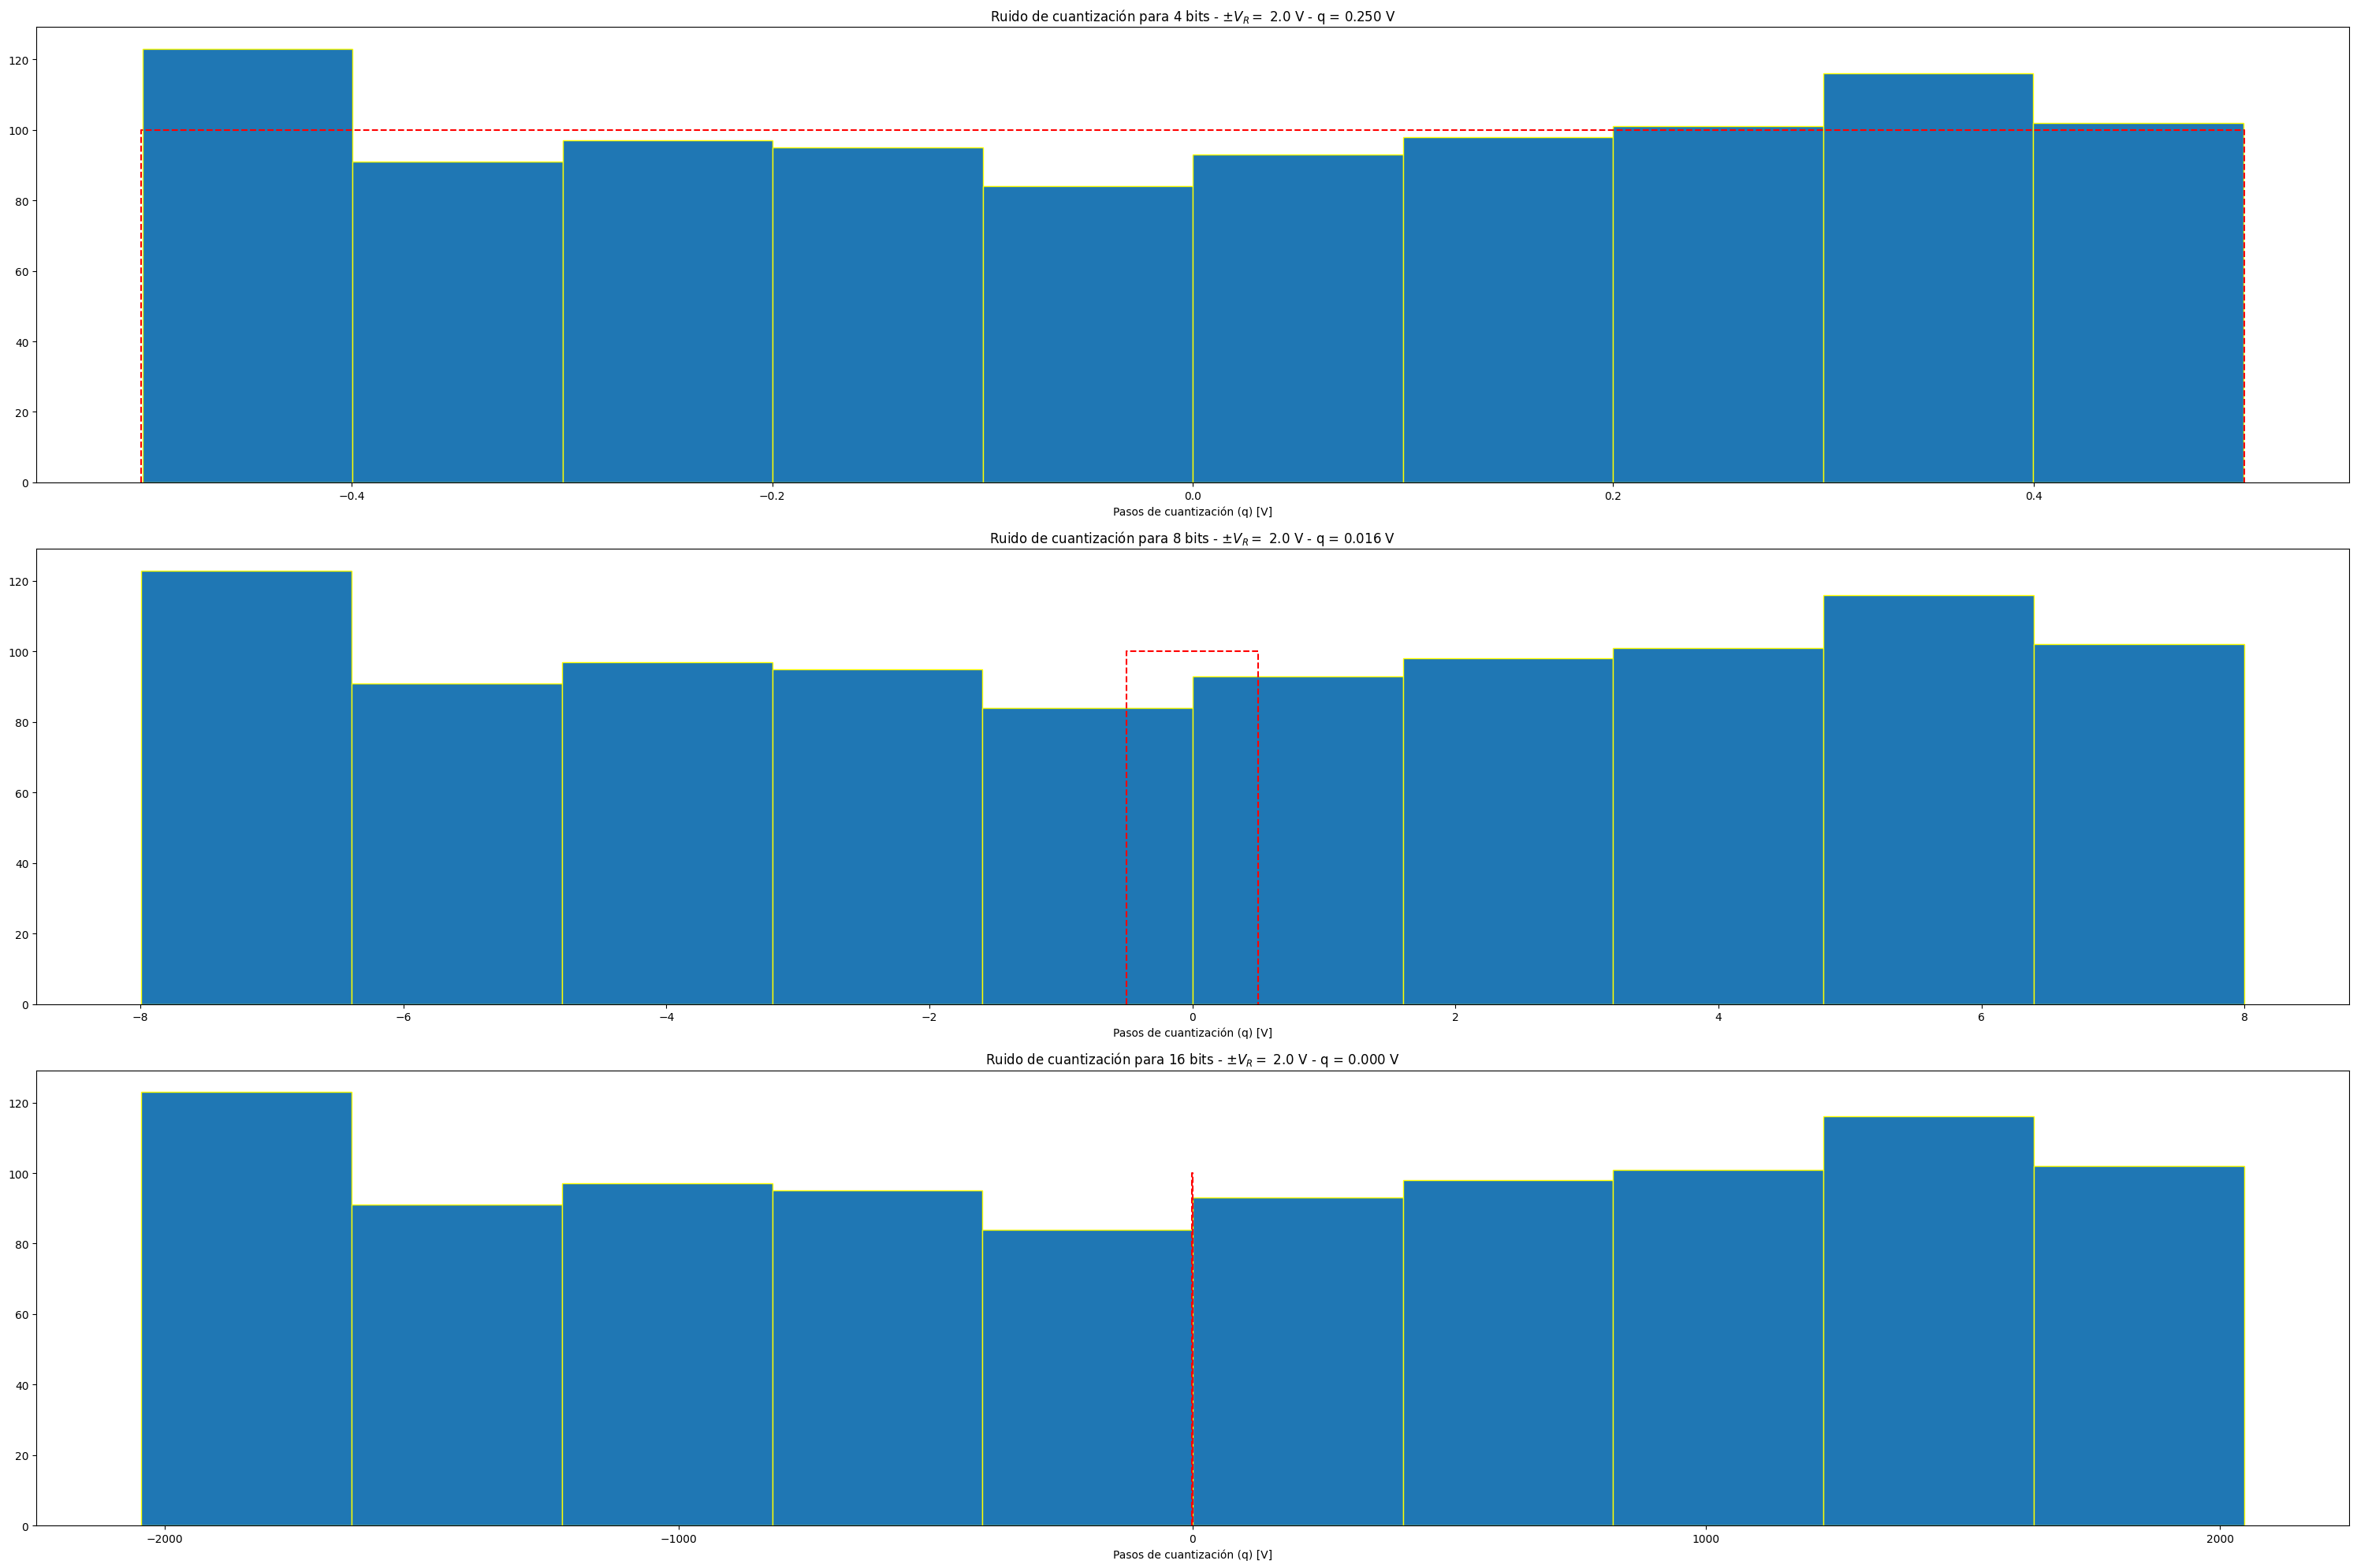

In [4]:
#%% Visualización de resultados de las simulaciones 2, 3 y 4

##################
# Señal temporal
##################

plt.figure(4, figsize=(20, 10))
plt.subplot(1,3,1)
plt.plot(tt, srq2, lw=2, linestyle='-', fillstyle='none', label=r'$S_Q2 = Q_{B,V_F}\{S_R\}$ (ADC out)')
plt.plot(tt, sr2, lw=3, color='green', marker='o', markerfacecolor='none', markeredgecolor='green', ls='dotted', label=r'$S_R2 = s + n2$ (ADC in)')
plt.plot(tt,s, lw=2, color='orange', linestyle='dotted', label=r'$s$ (analog)')
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B2, Vf, q2) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')  


plt.subplot(1,3,2)
plt.plot(tt, srq3, lw=2, linestyle='-', fillstyle='none', label=r'$S_Q3 = Q_{B,V_F}\{S_R\}$ (ADC out)')
plt.plot(tt, sr3, lw=3, color='green', marker='o', markerfacecolor='none', markeredgecolor='green', ls='dotted', label=r'$S_R3 = s + n3$ (ADC in)')
plt.plot(tt,s, lw=2, color='orange', linestyle='dotted', label=r'$s$ (analog)')
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B3, Vf, q3) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')  

plt.subplot(1,3,3)
plt.plot(tt, srq4, lw=2, linestyle='-', fillstyle='none', label=r'$S_Q4 = Q_{B,V_F}\{S_R\}$ (ADC out)')
plt.plot(tt, sr4, lw=3, color='green', marker='o', markerfacecolor='none', markeredgecolor='green', ls='dotted', label=r'$S_R4 = s + n4$ (ADC in)')
plt.plot(tt,s, lw=2, color='orange', linestyle='dotted', label=r'$s$ (analog)')
plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B4, Vf, q4) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')  

plt.tight_layout()

# ###########
# # Espectro de las simulaciones 2, 3 y 4
# ###########

# Crear figura con subplots de las simulaciones 2, 3 y 4
plt.figure(5, figsize=(20, 10))
plt.suptitle('Señal muestreada por un ADC de [{:d}; {:d}; {:d}] bits - $\\pm V_R= $ {:3.1f} V - q = [{:3.3f}; {:3.3f}; {:3.3f}] V - Kn = [{:3.1f}; {:d}; {:d}]'.format(B2, B3, B4, Vf, q2, q3, q4, kn2, kn3, kn4))

#Espectro
plt.subplot(3,2,1)
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_As[bfrec]) ** 2), color='orange', ls='dotted', label='$ s $ (analog)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([nNn2_mean, nNn2_mean])), '--r', label='$ \overline{n2} = $' + '{:3.1f} dB (piso analog.)'.format(10 * np.log10(2 * nNn2_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR2[bfrec]) ** 2), ':g', lw=2, label='$ s_R2 = s + n2 $ (ADC in)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq2[bfrec]) ** 2), lw=2, label='$ s_Q2 = Q_{B,V_F}\{s_R\}$ (ADC out)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([Nnq2_mean, Nnq2_mean])), '--c', label='$ \overline{n_Q2} = $' + '{:3.1f} dB (piso digital)'.format(10 * np.log10(2 * Nnq2_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nn2[bfrec]) ** 2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq2[bfrec]) ** 2), ':c')
plt.title('Espectro Completo de simulación con B=4 y Kn=1/10')
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()

#Zoom al espectro
plt.subplot(3,2,2)
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_As[bfrec]) ** 2), color='orange', ls='dotted', label='$ s $ (analog)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([nNn2_mean, nNn2_mean])), '--r', label='$ \overline{n2} = $' + '{:3.1f} dB (piso analog.)'.format(10 * np.log10(2 * nNn2_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR2[bfrec]) ** 2), ':g', lw=2, label='$ s_R2 = s + n2 $ (ADC in)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq2[bfrec]) ** 2), lw=2, label='$ s_Q2 = Q_{B,V_F}\{s_R\}$ (ADC out)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([Nnq2_mean, Nnq2_mean])), '--c', label='$ \overline{n_Q2} = $' + '{:3.1f} dB (piso digital)'.format(10 * np.log10(2 * Nnq2_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nn2[bfrec]) ** 2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq2[bfrec]) ** 2), ':c')
plt.title('Zoom del Espectro de simulación con B=4 y Kn=1/10')
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()
plt.ylim(-80, 0)

#Espectro
plt.subplot(3,2,3)
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_As[bfrec]) ** 2), color='orange', ls='dotted', label='$ s $ (analog)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([nNn3_mean, nNn3_mean])), '--r', label='$ \overline{n3} = $' + '{:3.1f} dB (piso analog.)'.format(10 * np.log10(2 * nNn3_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR3[bfrec]) ** 2), ':g', lw=2, label='$ s_R3 = s + n3 $ (ADC in)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq3[bfrec]) ** 2), lw=2, label='$ s_Q3 = Q_{B,V_F}\{s_R\}$ (ADC out)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([Nnq3_mean, Nnq3_mean])), '--c', label='$ \overline{n_Q3} = $' + '{:3.1f} dB (piso digital)'.format(10 * np.log10(2 * Nnq3_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nn3[bfrec]) ** 2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq3[bfrec]) ** 2), ':c')
plt.title('Espectro Completo de simulación con B=8 y Kn=1')
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()

#Zoom al espectro
plt.subplot(3,2,4)
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_As[bfrec]) ** 2), color='orange', ls='dotted', label='$ s $ (analog)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([nNn3_mean, nNn3_mean])), '--r', label='$ \overline{n3} = $' + '{:3.1f} dB (piso analog.)'.format(10 * np.log10(2 * nNn3_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR3[bfrec]) ** 2), ':g', lw=2, label='$ s_R3 = s + n3 $ (ADC in)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq3[bfrec]) ** 2), lw=2, label='$ s_Q3 = Q_{B,V_F}\{s_R\}$ (ADC out)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([Nnq3_mean, Nnq3_mean])), '--c', label='$ \overline{n_Q3} = $' + '{:3.1f} dB (piso digital)'.format(10 * np.log10(2 * Nnq3_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nn3[bfrec]) ** 2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq3[bfrec]) ** 2), ':c')
plt.title('Zoom del Espectro de simulación con B=8 y Kn=1')
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()
plt.ylim(-80, 0)

#Espectro
plt.subplot(3,2,5)
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_As[bfrec]) ** 2), color='orange', ls='dotted', label='$ s $ (analog)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([nNn4_mean, nNn4_mean])), '--r', label='$ \overline{n4} = $' + '{:3.1f} dB (piso analog.)'.format(10 * np.log10(2 * nNn4_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR4[bfrec]) ** 2), ':g', lw=2, label='$ s_R4 = s + n4 $ (ADC in)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq4[bfrec]) ** 2), lw=2, label='$ s_Q4 = Q_{B,V_F}\{s_R\}$ (ADC out)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([Nnq4_mean, Nnq4_mean])), '--c', label='$ \overline{n_Q4} = $' + '{:3.1f} dB (piso digital)'.format(10 * np.log10(2 * Nnq4_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nn4[bfrec]) ** 2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq4[bfrec]) ** 2), ':c')
plt.title('Espectro Completo de simulación con B=16 y Kn=10')
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()

#Zoom al espectro
plt.subplot(3,2,6)
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_As[bfrec]) ** 2), color='orange', ls='dotted', label='$ s $ (analog)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([nNn4_mean, nNn4_mean])), '--r', label='$ \overline{n4} = $' + '{:3.1f} dB (piso analog.)'.format(10 * np.log10(2 * nNn4_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR4[bfrec]) ** 2), ':g', lw=2, label='$ s_R4 = s + n4 $ (ADC in)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq4[bfrec]) ** 2), lw=2, label='$ s_Q4 = Q_{B,V_F}\{s_R\}$ (ADC out)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([Nnq4_mean, Nnq4_mean])), '--c', label='$ \overline{n_Q4} = $' + '{:3.1f} dB (piso digital)'.format(10 * np.log10(2 * Nnq4_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nn4[bfrec]) ** 2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq4[bfrec]) ** 2), ':c')
plt.title('Zoom del Espectro de simulación con B=16 y Kn=10')
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()
plt.ylim(-80, 0)

plt.tight_layout()

# #############
# # Histograma de las simulaciones 2, 3 y 4
# #############

plt.figure(6, figsize=(30,20))
plt.subplot(3,1,1)
plt.hist(nq.flatten()/(q2), bins=bins, edgecolor='yellow')
plt.plot( np.array([-1/2, -1/2, 1/2, 1/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B2, Vf, q2))
plt.xlabel('Pasos de cuantización (q) [V]')

plt.subplot(3,1,2)
plt.hist(nq.flatten()/(q3), bins=bins, edgecolor='yellow')
plt.plot( np.array([-1/2, -1/2, 1/2, 1/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B3, Vf, q3))
plt.xlabel('Pasos de cuantización (q) [V]')

plt.subplot(3,1,3)
plt.hist(nq.flatten()/(q4), bins=bins, edgecolor='yellow')
plt.plot( np.array([-1/2, -1/2, 1/2, 1/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B4, Vf, q4))
plt.xlabel('Pasos de cuantización (q) [V]')

plt.tight_layout()

### Análisis de resultados de la consigna B
Al incrementar la cantidad de bits como así también aumentar la escala de potencia del ruido de cuantización, esto conlleva en la señal temporal una menor distorsión, ya que el paso de cuantización es muy pequeño, y una disminución de la potencia del ruido de cuantización. De esta forma, mejora la aproximación continua de la señal.

Por su parte, de los espectros se pondera la reducción del ruido de cuantización y el aumento del ruido analógico conforme incrementa la cantidad de bins, siendo el ruido analógico el principal limitante en la calidad de la señal.

Por otro lado, los histogramas de ruido de cuantización constatan la tendencia a seguir una distribución uniforme y la disminución del tamaño de los bins alrededor del origen

## Resolución Bonus 1

La relación entre la cantidad de B bits del ADC y el SNR (relación potencia de la señal - potencia del ruido) de la señal digitalizada se obtiene de ponderar inicialmente que la potencia del ruido de cuantización producto del ADC se expresa como 
\begin{equation}
P_{nq} =\sigma_e^2 = \int_{-q/2}^{q/2} e^2 p_e(e) \, de = \frac{1}{q} \int_{-q/2}^{q/2} e^2 \, de
\end{equation}

\begin{equation}
= \frac{1}{q} \cdot \frac{q^3}{12} = \frac{q^2}{12}
\end{equation}

Donde $p_e(e) = 1/q$, $e = q/2$ y $q = V_{FS}/2^{B}$.

Además, para un ADC bipolar de $B$ bits con un voltaje de escala completa $V_{FS} = 2V_{REF}$,la ecuación previa relaciona $q$, $B$ y $V_{FS}$ al sustituir $q$:

\begin{equation}
\sigma_e^2 = \frac{q^2}{12} = \frac{V_{FS}^2}{12 \cdot 2^{2B}}
\end{equation}

Cabe destacar que $V_{REF}$ consiste en el voltaje de referencia máximo que el ADC puede medir.

Posteriomente, la potencia $(P_x)$ de una señal senoidal $x[n]$ se define como la varianza  $\sigma_x^2 = V_{REF}^2/2$.

En efecto, la relación señal-ruido (SNR) es proporcional al logaritmo en base 10 de:

\begin{equation}
SNR = 10\log_{10} \left(\frac{\sigma_x^2}{\sigma_e^2}\right) = 10\log_{10} \left(\frac{12 \cdot 2^{2N} \sigma_x^2}{V_{FS}^2}\right) = \frac{3 \cdot 2^{2B}}{2}
\end{equation}

## Resolución Bonus 2

### Código asociado a la consigna B

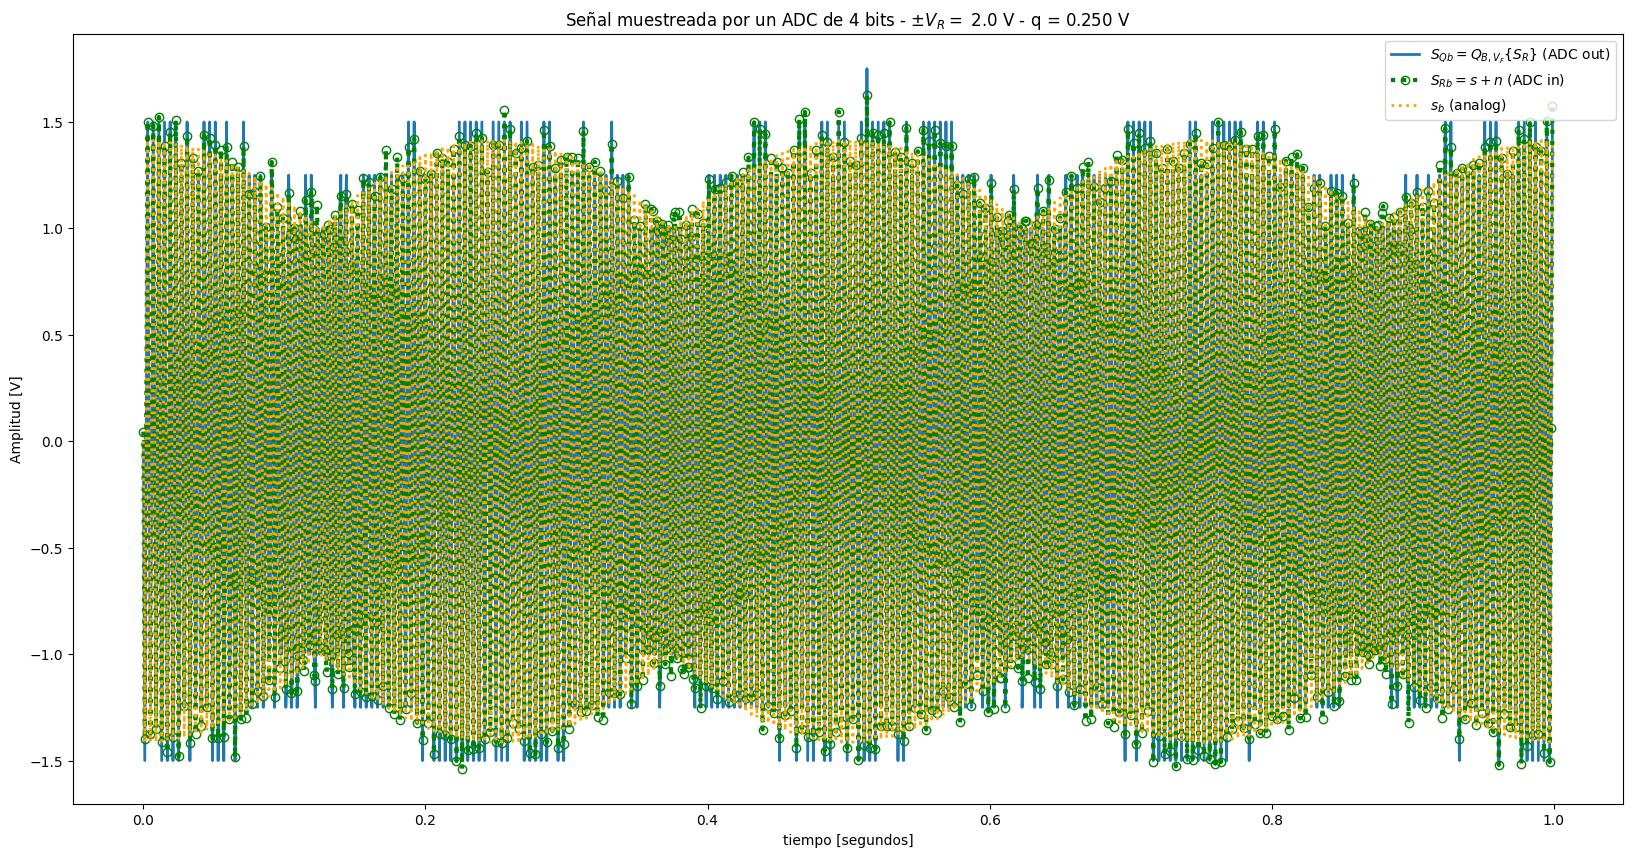

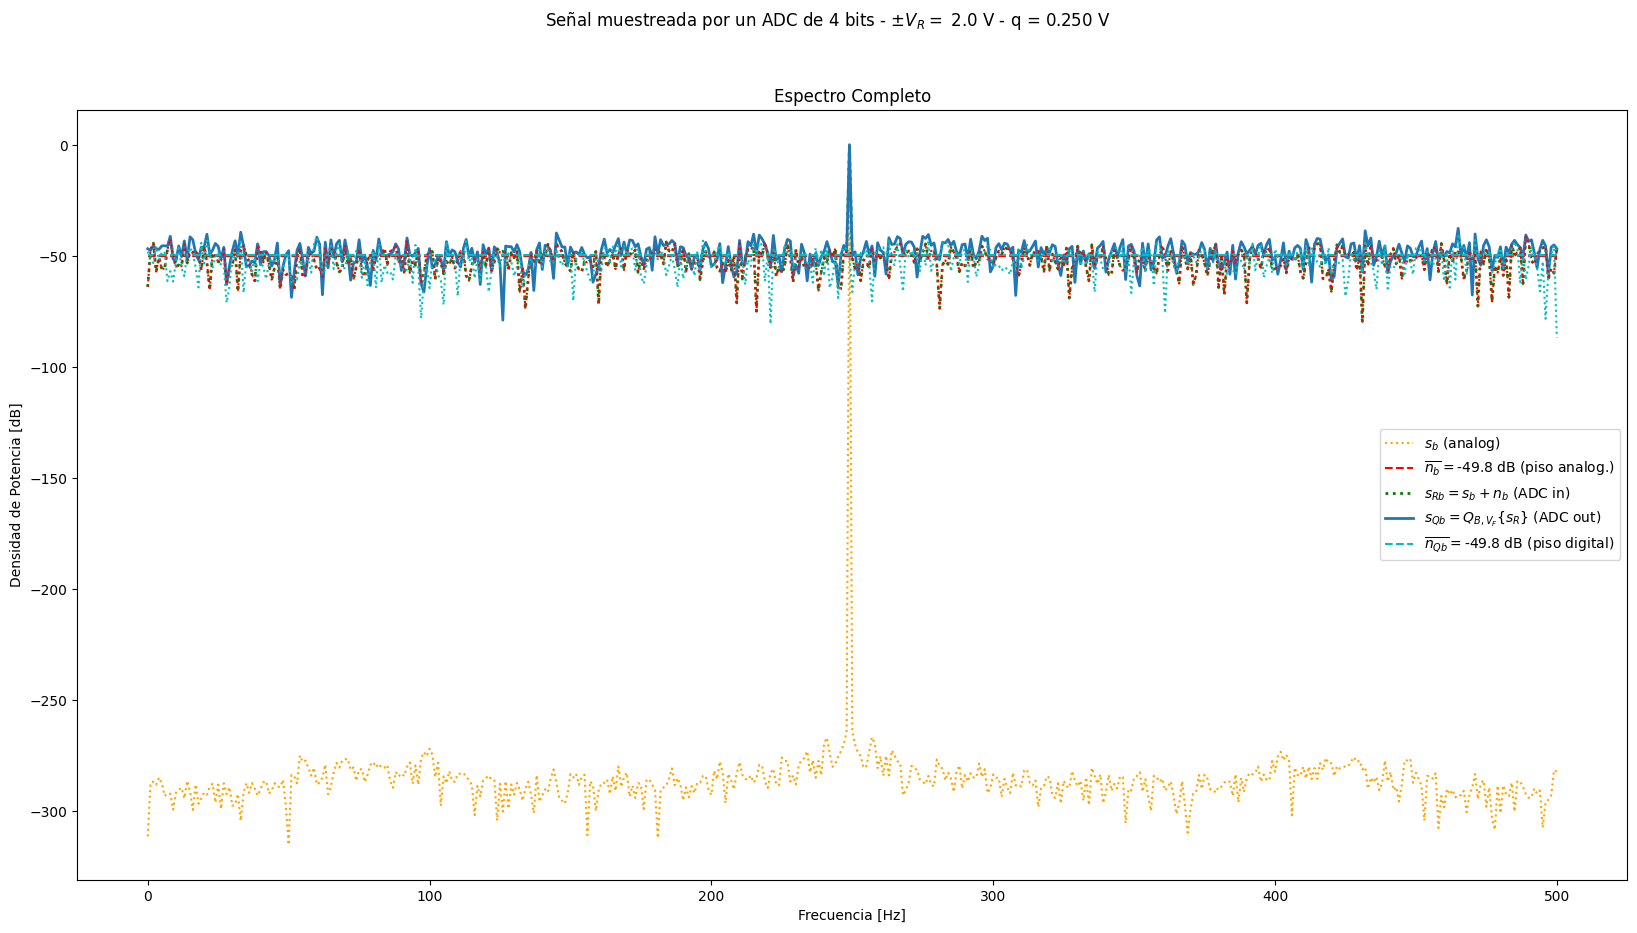

In [13]:
f0b=751
analog_sig_sn=amplitud * np.sin( 2 * np.pi * f0b * tt )# señal analógica sin ruido no normalizada
sb = analog_sig_sn/np.var(analog_sig_sn)# señal analógica sin ruido de energia normalizada (varianza=1) y potencia 1W

nb =  np.random.normal(0, np.sqrt(Pn),N) # señal de ruido analogico Gaussiano e incorrelado
srb = sb + nb # señal analógica de entrada al ADC (señal + ruido analógico)
srqb = np.round(srb/q)*q  # señal cuantizada (escalo a valor palabra y luego vuelvo a mi escala)
nqb = srqb - srb # señal de ruido de cuantización (señal cuantizada - señal con ruido analogico).

#FFT
ft_SRb = 1/N*np.fft.fft( srb)
ft_Srqb = 1/N*np.fft.fft( srqb)
ft_Asb = 1/N*np.fft.fft( sb)
ft_Nqb = 1/N*np.fft.fft( nqb)
ft_Nnb = 1/N*np.fft.fft( nb)

#valor de la media
Nnqb_mean = np.mean(np.abs(ft_Nqb)**2)
nNnb_mean = np.mean(np.abs(ft_Nnb)**2)

#%% Visualización de resultados Bonus B

##################
# Señal temporal
##################

plt.figure(7, figsize=(20, 10))

plt.plot(tt, srqb, lw=2, linestyle='-', fillstyle='none', label=r'$S_{Qb} = Q_{B,V_F}\{S_R\}$ (ADC out)')
plt.plot(tt, srb, lw=3, color='green', marker='o', markerfacecolor='none', markeredgecolor='green', ls='dotted', label=r'$S_{Rb} = s + n$ (ADC in)')
plt.plot(tt,sb, lw=2, color='orange', linestyle='dotted', label=r'$s_b$ (analog)')

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')  
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()

# ###########
# # Espectro
# ###########

# Crear figura con subplots
plt.figure(8, figsize=(20, 10))
plt.suptitle('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )

#Espectro
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Asb[bfrec]) ** 2), color='orange', ls='dotted', label='$ s_b $ (analog)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([nNnb_mean, nNnb_mean])), '--r', label='$ \overline{n_b} = $' + '{:3.1f} dB (piso analog.)'.format(10 * np.log10(2 * nNnb_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SRb[bfrec]) ** 2), ':g', lw=2, label='$ s_{Rb} = s_b + n_b $ (ADC in)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srqb[bfrec]) ** 2), lw=2, label='$ s_{Qb} = Q_{B,V_F}\{s_R\}$ (ADC out)')
plt.plot(np.array([ff[bfrec][0], ff[bfrec][-1]]), 10 * np.log10(2 * np.array([Nnqb_mean, Nnqb_mean])), '--c', label='$ \overline{n_{Qb}} = $' + '{:3.1f} dB (piso digital)'.format(10 * np.log10(2 * Nnqb_mean)))
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nnb[bfrec]) ** 2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nqb[bfrec]) ** 2), ':c')
plt.title('Espectro Completo')
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.legend()

### Análisis de resultados de la consigna Bonus 2
Por un lado, en la secuencia temporal se evidencia la alteración de la periodicidad (o dispersión de los valores) dado que esta no coincide con N a razón de que la resolución espectral es distinta de uno.
Por otro lado, en el espectro de frecuencias se verifica que hay una dispersión de la energía a causa del reflejo de las frecuencias de la señal mayores a la frecuencia de Nyquist.

## Conclusiones
Finalmente, a partir de las consignas de este trabajo se dedujeron las propiedades de la señal, el ruido digital y el ruido analógico expuestas por los gráficos en el dominio temporal y frecuencial, y los histogramas mediante la variación de los parámetros asociados a la cantidad de bins y la escala de potencia. En adición, se estudio el efecto aliasing y la relación cantidad de B bits del ADC y el SNR de la señal digitalizada.
Además, la IA fue empleada en la configuración de ciertos gráficos de la consigna B, y la bibliografía de la materia fue utilizada para la resolución de los puntos bonus. 
También, los resultados fueron contrastados con el ejemplo analizado durante las clases previas debido a sus similitudes.